<a href="https://colab.research.google.com/github/ritwiks9635/CNN_Project_File/blob/main/Fish_Detection_using_YOLO_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Fish Detection Using YOLO Model** 🐟🐠🐡🦈🐟🐠🐡🦈🐟🐠🐡🦈

In [ ]:
! unzip /content/https:/www.kaggle.com/datasets/trainingdatapro/fish-tracking-dataset/fish-tracking-dataset.zip

In [ ]:
import shutil
from IPython.lib.display import exists
import xml.etree.ElementTree as ET

In [ ]:
import pandas as pd
data = pd.read_xml("/content/annotations.xml")

In [ ]:
data.head()

,version,task,dumped,id,name,width,height,box
0,1.1,NaN,None,NaN,None,NaN,NaN,NaN
1,NaN,NaN,2023-08-14 09:25:08.383692+00:00,NaN,None,NaN,NaN,NaN
2,NaN,NaN,None,1.0,images/01.jpg,1752.0,986.0,NaN
3,NaN,NaN,None,2.0,images/02.jpg,1752.0,986.0,NaN
4,NaN,NaN,None,3.0,images/03.jpg,1752.0,986.0,NaN


***Converting XML Annotations to YOLO Format***

In [ ]:
def xml_to_yolo(xml_file, class_id):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    for image_elem in root.findall('image'):
        image_id = image_elem.get('id')
        image_name = image_elem.get('name')
        image_name = image_name.split('images/')[1]
        image_name = image_name.split('.')[0]
        print(image_name)
        image_width = int(image_elem.get('width'))
        image_height = int(image_elem.get('height'))

        yolo_lines = []
        for box_elem in image_elem.findall('box'):
            label = box_elem.get('label')
            occluded = int(box_elem.get('occluded'))
            xtl = float(box_elem.get('xtl'))
            ytl = float(box_elem.get('ytl'))
            xbr = float(box_elem.get('xbr'))
            ybr = float(box_elem.get('ybr'))

            # Calculate center coordinates, width, and height
            center_x = (xtl + xbr) / (2 * image_width)
            center_y = (ytl + ybr) / (2 * image_height)
            width = (xbr - xtl) / image_width
            height = (ybr - ytl) / image_height

            # Create a YOLO line
            yolo_line = f"{class_id} {center_x} {center_y} {width} {height}"

            # Append the YOLO line to the list
            yolo_lines.append(yolo_line)

        # Save YOLO annotations to a text file with the same name as the image_id
        if not os.path.exists('/content/working/train_txt/labels'):
          os.makedirs('/content/working/train_txt/labels')
        txt_file_path = os.path.join('/content/working/train_txt/labels', f"{image_name}.txt")
        with open(txt_file_path, 'w') as txt_file:
            txt_file.write('\n'.join(yolo_lines))

In [ ]:
xml_path = "/content/annotations.xml"
class_id = 0

In [ ]:
xml_to_yolo(xml_path, class_id)

01
02
03
04
05
06
07
08
09
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [ ]:
import random

***Splitting Data into Training and Validation Sets***

In [ ]:
def split_train_val_data(txt_files_dir, train_dir, val_dir, val_split_ratio=0.2):
    # Create train and validation directories if they don't exist
    os.makedirs(os.path.join(train_dir, 'images'), exist_ok=True)
    os.makedirs(os.path.join(train_dir, 'labels'), exist_ok=True)
    os.makedirs(os.path.join(val_dir, 'images'), exist_ok=True)
    os.makedirs(os.path.join(val_dir, 'labels'), exist_ok=True)

    txt_files = os.listdir(txt_files_dir)
    random.shuffle(txt_files)

    num_val_samples = int(val_split_ratio * len(txt_files))
    val_files = txt_files[:num_val_samples]
    train_files = txt_files[num_val_samples:]

    for val_file in val_files:
        src_txt_path = os.path.join(txt_files_dir, val_file)
        dest_txt_path = os.path.join(val_dir, 'labels', val_file)
        shutil.move(src_txt_path, dest_txt_path)

        # Assuming your image filenames match the annotation filenames with the .jpg extension
        image_filename = os.path.splitext(val_file)[0] + '.jpg'
        src_img_path = os.path.join('/content/images/', image_filename)
        dest_img_path = os.path.join(val_dir, 'images', image_filename)
        shutil.copy(src_img_path, dest_img_path)

    for train_file in train_files:
        src_txt_path = os.path.join(txt_files_dir, train_file)
        dest_txt_path = os.path.join(train_dir, 'labels', train_file)
        shutil.copy(src_txt_path, dest_txt_path)

        # Assuming your image filenames match the annotation filenames with the .jpg extension
        image_filename = os.path.splitext(train_file)[0] + '.jpg'
        src_img_path = os.path.join('/content/images/', image_filename)
        dest_img_path = os.path.join(train_dir, 'images', image_filename)
        shutil.move(src_img_path, dest_img_path)

In [ ]:
# Directory containing YOLO annotation files
txt_files_dir = '/content/working/train_txt/labels'
train_dir = '/content/working/train'
val_dir = '/content/working/val'

# Split the data into train and validation sets
split_train_val_data(txt_files_dir, train_dir, val_dir, val_split_ratio=0.2)

***Loading YOLO Models with Ultralytics***

In [ ]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 616.5/616.5 kB 10.5 MB/s eta 0:00:00


In [ ]:
!pip install pyyaml

**ultralytics**: The Ultralytics library provides functionalities for the YOLO object detection framework.

In [ ]:
from ultralytics import YOLO

model = YOLO('yolov8s.pt')

100%|██████████| 21.5M/21.5M [00:03<00:00, 6.96MB/s]


***Creating and Saving a YAML Configuration File***

In [ ]:
import yaml

# Define your configuration data as a Python dictionary
config = {
    'path': '/content/working',
    'train': 'train/images',  # train images (relative to 'path') 4 images
    'val': 'val/images',      # val images (relative to 'path') 4 images
    'nc': 1,                   # Number of classes
    'names': ['Fish'],         # Class names
    # 'fl_gamma': 2.0          # Uncomment this line if needed
}

# Define the file path where you want to save the YAML file
yaml_file_path = '/content/working/config.yaml'  # Update with your desired path and file name

# Write the YAML data to the file
with open(yaml_file_path, 'w') as yaml_file:
    yaml.dump(config, yaml_file)

print(f"YAML configuration file saved at: {yaml_file_path}")

YAML configuration file saved at: /content/working/config.yaml


***Training the YOLO Model with Ultralytics***

In [ ]:
results = model.train(data='/content/working/config.yaml',
                      epochs=220,
                      imgsz=640,
                      pretrained = True ,
                      name= "fish_small",
                      patience = 35,
                      flipud=0.5,
                      batch = 32,
                      optimizer = 'SGD',
                      augment = True
                      )

Ultralytics YOLOv8.0.192 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/working/config.yaml, epochs=220, patience=35, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=fish_small, exist_ok=False, pretrained=True, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False

***Validating the YOLO Model with Ultralytics***

In [ ]:
model = YOLO('/content/runs/detect/fish_small/weights/best.pt')
results = model.val()
for i in [0.25,0.15,0.05]:
  results = model.val(name= f'cofidence: {i}', conf= i , iou=0.8)

Ultralytics YOLOv8.0.192 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11125971 parameters, 0 gradients, 28.4 GFLOPs
val: Scanning /content/working/val/labels.cache... 19 images, 0 backgrounds, 0 corrupt: 100%|██████████| 19/19 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.51it/s]
                   all         19        179      0.988      0.958      0.983      0.848
Speed: 5.8ms preprocess, 23.6ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/detect/val
Ultralytics YOLOv8.0.192 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
val: Scanning /content/working/val/labels.cache... 19 images, 0 backgrounds, 0 corrupt: 100%|██████████| 19/19 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.23it/s]
          

In [ ]:
model = YOLO('/content/runs/detect/fish_small/weights/best.pt')

In [ ]:
import numpy as np
import PIL
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt
from glob import glob
import cv2
import warnings
warnings.simplefilter('ignore')

***Displaying Random Sample Images from Validation Set***

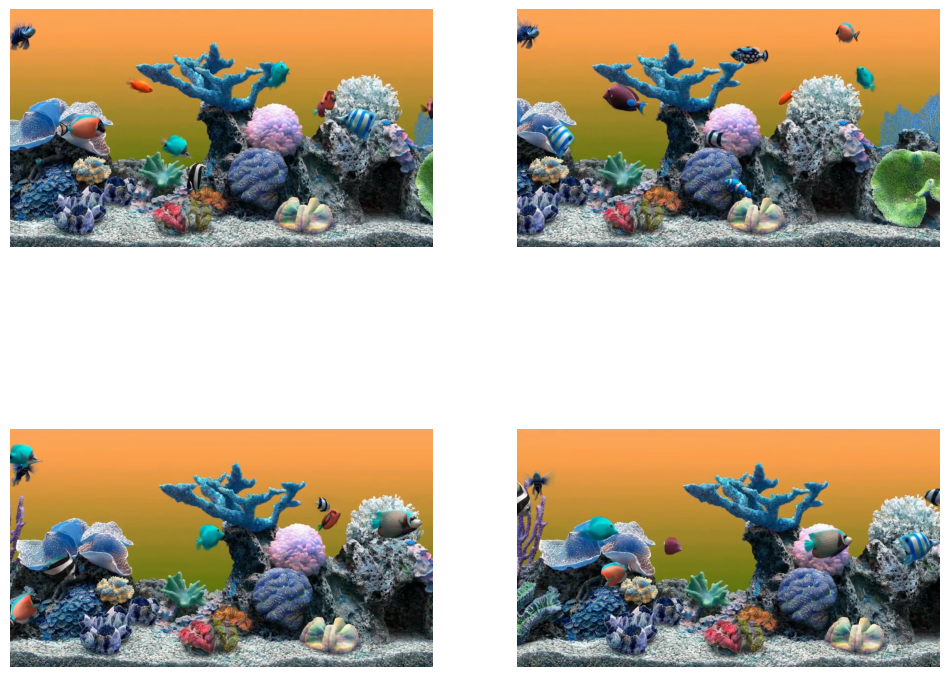

In [ ]:
root_path = '/content/working/val/images/*'
num_samples = 4
images_data = glob(root_path)
random_image = random.sample(images_data, num_samples)

plt.figure(figsize=(12,10))
for i in range(num_samples):
    plt.subplot(2,2,i+1)
    plt.imshow(cv2.imread(random_image[i]))
    plt.axis('off')

***Predicting and Displaying Object Detections on Sample Images***

In [ ]:
images = []
for i in range(num_samples):
    yolo_outputs = model.predict(random_image[i])
    output = yolo_outputs[0]
    box = output.boxes
    names = output.names
    print('**********************')
    for j in range(len(box)):
        labels = names[box.cls[j].item()]
        coordinates = box.xyxy[j].tolist()
        confidence = np.round(box.conf[j].item(), 2)
        print(f'In this image {len(box)} fish has been detected.')
        print(f'Fish {j + 1} is: {labels}')
        print(f'Coordinates are: {coordinates}')
        print(f'Confidence is: {confidence}')
        print('-------')

    # Store the image in the 'images' list
    images.append(output.plot()[:, :, ::-1])


image 1/1 /content/working/val/images/51.jpg: 384x640 12 Fishs, 10.9ms
Speed: 2.1ms preprocess, 10.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/working/val/images/81.jpg: 384x640 9 Fishs, 10.9ms
Speed: 2.1ms preprocess, 10.9ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/working/val/images/37.jpg: 384x640 8 Fishs, 10.8ms
Speed: 2.0ms preprocess, 10.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



**********************
In this image 12 fish has been detected.
Fish 1 is: Fish
Coordinates are: [619.6791381835938, 521.3425903320312, 757.8074340820312, 620.0927124023438]
Confidence is: 0.91
-------
In this image 12 fish has been detected.
Fish 2 is: Fish
Coordinates are: [202.24154663085938, 437.4521789550781, 397.8011169433594, 542.5159301757812]
Confidence is: 0.91
-------
In this image 12 fish has been detected.
Fish 3 is: Fish
Coordinates are: [1343.77685546875, 410.8567810058594, 1521.1912841796875, 545.356201171875]
Confidence is: 0.9
-------
In this image 12 fish has been detected.
Fish 4 is: Fish
Coordinates are: [1061.1580810546875, 216.68167114257812, 1159.614501953125, 340.88275146484375]
Confidence is: 0.9
-------
In this image 12 fish has been detected.
Fish 5 is: Fish
Coordinates are: [0.40883302688598633, 43.17241287231445, 108.68424987792969, 173.3057098388672]
Confidence is: 0.89
-------
In this image 12 fish has been detected.
Fish 6 is: Fish
Coordinates are: [476

image 1/1 /content/working/val/images/27.jpg: 384x640 8 Fishs, 10.8ms
Speed: 1.9ms preprocess, 10.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


**********************
In this image 8 fish has been detected.
Fish 1 is: Fish
Coordinates are: [1579.212646484375, 426.94891357421875, 1748.4036865234375, 562.1057739257812]
Confidence is: 0.92
-------
In this image 8 fish has been detected.
Fish 2 is: Fish
Coordinates are: [1190.6932373046875, 410.2510986328125, 1390.812255859375, 539.9326171875]
Confidence is: 0.91
-------
In this image 8 fish has been detected.
Fish 3 is: Fish
Coordinates are: [605.1082763671875, 447.19476318359375, 686.1751708984375, 520.9086303710938]
Confidence is: 0.91
-------
In this image 8 fish has been detected.
Fish 4 is: Fish
Coordinates are: [344.1950988769531, 548.1060180664062, 479.6910705566406, 654.582275390625]
Confidence is: 0.9
-------
In this image 8 fish has been detected.
Fish 5 is: Fish
Coordinates are: [270.4420166015625, 360.91357421875, 423.556396484375, 463.6896057128906]
Confidence is: 0.89
-------
In this image 8 fish has been detected.
Fish 6 is: Fish
Coordinates are: [1684.140869140625

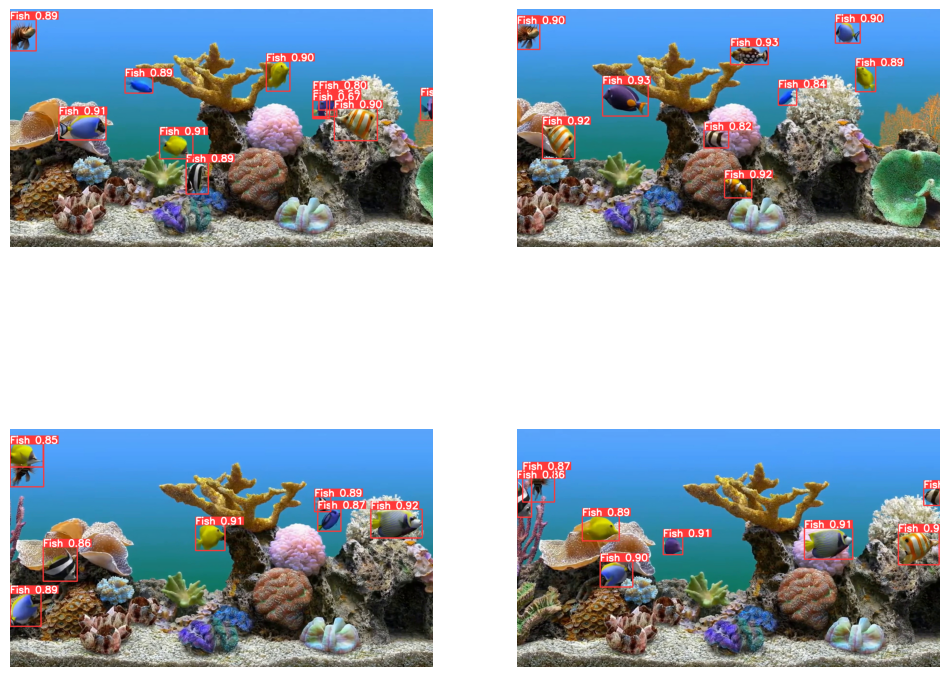

In [ ]:
plt.figure(figsize=(12,10))
for i, img in enumerate(images):
    plt.subplot(2, 2, i + 1)
    plt.imshow(img)
    plt.axis('off')